In [1]:
import pandas as pd

train = pd.read_excel("../../Dataset/train_data.xlsx", index_col=False)
test = pd.read_excel("../../Dataset/test_data.xlsx", index_col=False)
X_train = train.iloc[:, 6:]
y_train = train["P"]

X_test = test.iloc[:, 6:]
y_test = test["P"]

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import numpy as np


# Function for hyperparameter optimization using hyperopt
def optimize_hyperparameters(X, y, cv=5, max_evals=50):
    def objective(params):
        model = RandomForestRegressor(**params, random_state=42)
        scores = cross_val_score(
            model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1
        )
        return {"loss": -np.mean(scores), "status": STATUS_OK}

    param_space = {
        "n_estimators": hp.choice("n_estimators", [50, 100, 200]),
        "max_depth": hp.choice("max_depth", [3, 6, 9]),
        "min_samples_split": hp.choice("min_samples_split", [2, 5, 10]),
        "min_samples_leaf": hp.choice("min_samples_leaf", [1, 2, 4]),
        "max_features": hp.choice("max_features", ["sqrt", "log2"]),
    }

    trials = Trials()
    best_params = fmin(
        fn=objective,
        space=param_space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
    )

    # Convert indices to actual values
    best_params["n_estimators"] = [50, 100, 200][best_params["n_estimators"]]
    best_params["max_depth"] = [3, 6, 9][best_params["max_depth"]]
    best_params["min_samples_split"] = [2, 5, 10][best_params["min_samples_split"]]
    best_params["min_samples_leaf"] = [1, 2, 4][best_params["min_samples_leaf"]]
    best_params["max_features"] = ["sqrt", "log2"][best_params["max_features"]]

    return best_params

In [3]:
def get_top_n_features(X_train, y_train, best_params, n):
    # Train the ExtraTreesRegressor model
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(X_train, y_train)

    # Get feature importances
    feature_importances = model.feature_importances_

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame(
        {"Feature": X_train.columns, "Importance": feature_importances}
    )

    # Sort features by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(
        by="Importance", ascending=False
    )

    feature_importance_df.to_excel(
        "../Results/rf_feature_importance_P.xlsx", index=False
    )
    # Return the top n features
    return feature_importance_df.head(n)

In [4]:
# Optimize hyperparameters
best_params = optimize_hyperparameters(X_train, y_train, cv=5)

100%|██████████| 50/50 [00:36<00:00,  1.36trial/s, best loss: 2.565040307000742] 


In [5]:
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
import json

# Save best_params to a JSON file
with open("../Results/rf_best_params_P.json", "w") as json_file:
    json.dump(best_params, json_file)

In [7]:
# Train and evaluate model
top_n_features = get_top_n_features(X_train, y_train, best_params, 50)
top_n_features

,Feature,Importance
93,MolLogP,0.075209
60,TPSA,0.057693
15,BCUT2D_MWHI,0.050421
89,NumHeteroatoms,0.033215
8,MaxPartialCharge,0.032007
83,NOCount,0.027877
79,VSA_EState8,0.027588
10,MaxAbsPartialCharge,0.026848
1,MaxEStateIndex,0.024602
41,PEOE_VSA6,0.024415


In [8]:
import matplotlib.pyplot as plt


def plot_r2_vs_features(
    X_train, y_train, X_test, y_test, best_params, top_n_features, max_features
):
    r2_scores_train = []
    r2_scores_test = []

    for n in range(1, max_features + 1):
        # Select top n features
        features = top_n_features["Feature"][:n]

        # Train model with top n features
        model = RandomForestRegressor(**best_params, random_state=42)
        X_train_top_n = X_train[features]
        X_test_top_n = X_test[features]
        model.fit(X_train_top_n, y_train)

        # Evaluate R²
        r2_train = r2_score(y_train, model.predict(X_train_top_n))
        r2_test = r2_score(y_test, model.predict(X_test_top_n))

        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)

    # Plot R² vs number of features
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_features + 1), r2_scores_train, label="Train R²", marker="o")
    plt.plot(range(1, max_features + 1), r2_scores_test, label="Test R²", marker="o")
    plt.xlabel("Number of Features")
    plt.ylabel("R² Score")
    plt.title("R² Score vs Number of Features")
    plt.legend()
    plt.grid()
    plt.show()

    selected_result = pd.DataFrame(
        {
            "r2_scores_train": r2_scores_train,
            "r2_scores_test": r2_scores_test,
        }
    )

    selected_result.to_excel("../Results/rf_top_n_feats_P.xlsx")

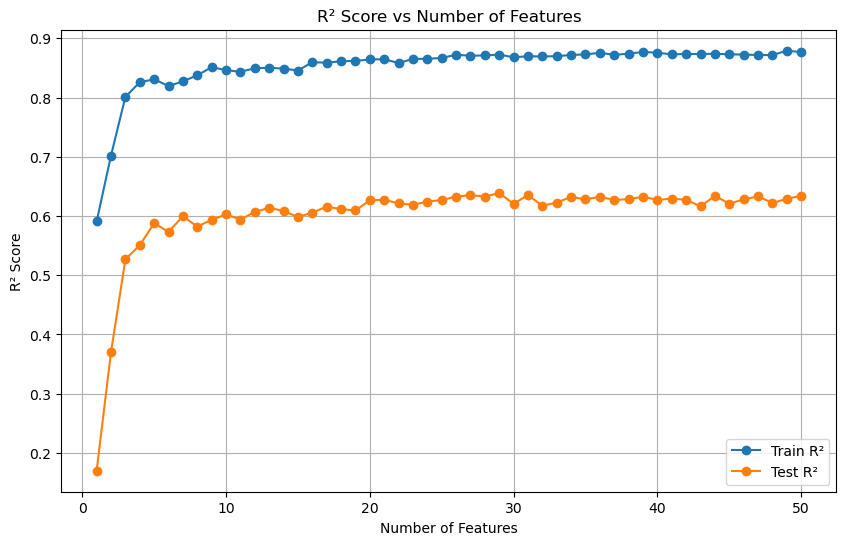

In [9]:
# Example usage for D
plot_r2_vs_features(
    X_train, y_train, X_test, y_test, best_params, top_n_features, len(top_n_features)
)